In [65]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from shapely.geometry import Point
from pathlib import Path
from scipy import stats
import contextily as ctx
from mpl_toolkits.basemap import Basemap
import mplleaflet

In [44]:
os.chdir(os.path.join(str(Path.home()),"isd-lite/data_light"))

In [45]:
df=pd.read_csv('stationAttr72.csv')
df.head(),df.shape

(  stationNumber     slope  lowBound  hightBound  slopeInt  pw1972  pw2017
 0  483570-99999 -0.134197 -0.185880   -0.082513        -1   135.0    74.0
 1  722310-12916 -0.083380 -0.148009   -0.018750        -1    78.0   121.0
 2  702710-26425 -0.092815 -0.161811   -0.023820        -1   190.0   157.0
 3  948420-99999 -0.286895 -0.391642   -0.182148        -1   287.0   292.0
 4  943320-99999  0.347579  0.278563    0.416596         1   119.0   131.0,
 (88, 7))

In [46]:
#let's check if there are any NAN's in any of the rows
df.isnull().values.any()

True

In [47]:
#check to see where the null values are
df.isnull().sum()

stationNumber    0
slope            1
lowBound         1
hightBound       1
slopeInt         0
pw1972           0
pw2017           0
dtype: int64

In [48]:
#since there are some null values, we will drop the row(s) with null values
df = df.dropna()
#pandas does not reset index where drop takes place
df.reset_index(drop=True, inplace=True)

df.shape

(87, 7)

In [49]:
#Need to add some attributes from ID_Info.csv
df_id = pd.read_csv("ID_Info.csv")
df_id.head()

,ID,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,Timespan
0,008268-99999,8268,99999,WXPOD8278,AF,NaN,NaN,32.950,65.567,1156.7,2010-05-19,2012-03-23,674
1,010010-99999,10010,99999,JAN MAYEN(NOR-NAVY),NO,NaN,ENJA,70.933,-8.667,9.0,1931-01-01,2017-05-22,31553
2,010014-99999,10014,99999,SORSTOKKEN,NO,NaN,ENSO,59.792,5.341,48.8,1986-11-20,2017-05-22,11141
3,010015-99999,10015,99999,BRINGELAND,NO,NaN,NaN,61.383,5.867,327.0,1987-01-17,2011-10-20,9042
4,010016-99999,10016,99999,RORVIK/RYUM,NO,NaN,NaN,64.850,11.233,14.0,1987-01-16,1991-08-06,1663


In [50]:
#add the columns that we will get from ID_Info.csv to df
df["elev"] = np.nan
df["lat"] = np.nan
df["lon"] = np.nan
df.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,pw1972,pw2017,elev,lat,lon
0,483570-99999,-0.134197,-0.185880,-0.082513,-1,135.0,74.0,NaN,NaN,NaN
1,722310-12916,-0.083380,-0.148009,-0.018750,-1,78.0,121.0,NaN,NaN,NaN
2,702710-26425,-0.092815,-0.161811,-0.023820,-1,190.0,157.0,NaN,NaN,NaN
3,948420-99999,-0.286895,-0.391642,-0.182148,-1,287.0,292.0,NaN,NaN,NaN
4,943320-99999,0.347579,0.278563,0.416596,1,119.0,131.0,NaN,NaN,NaN


In [51]:
#fill in the new columns with info from ID_Info.csv
nr = df.shape[0]
for i in range(nr):
    sn = df["stationNumber"][i]
    
    #get the index in df_id associated with that staion number
    idx = df_id.index[df_id['ID']==sn][0]
    
    df.loc[[i],['elev']] = df_id["ELEV(M)"][idx]
    df.loc[[i],['lat']] = df_id["LAT"][idx]
    df.loc[[i],['lon']] = df_id["LON"][idx]
df.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,pw1972,pw2017,elev,lat,lon
0,483570-99999,-0.134197,-0.185880,-0.082513,-1,135.0,74.0,148.0,17.417,104.783
1,722310-12916,-0.083380,-0.148009,-0.018750,-1,78.0,121.0,1.2,29.998,-90.278
2,702710-26425,-0.092815,-0.161811,-0.023820,-1,190.0,157.0,476.1,62.159,-145.459
3,948420-99999,-0.286895,-0.391642,-0.182148,-1,287.0,292.0,83.0,-38.850,143.517
4,943320-99999,0.347579,0.278563,0.416596,1,119.0,131.0,341.7,-20.664,139.489


In [52]:
dfNeg = df[df['slopeInt']== -1]
dfZero = df[df['slopeInt']== 0]
dfPos = df[df['slopeInt']== 1]

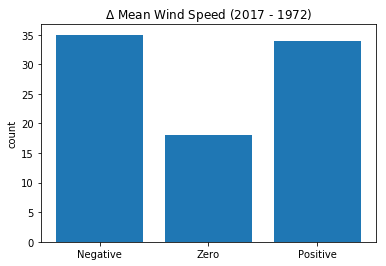

In [53]:
#plot the number of neg,zero,pos trends
x = np.arange(3)
plt.bar(x,[len(dfNeg), len(dfZero), len(dfPos)])
plt.xticks(x,("Negative","Zero", "Positive"));
plt.title("$\Delta$ Mean Wind Speed (2017 - 1972)")
plt.ylabel("count");

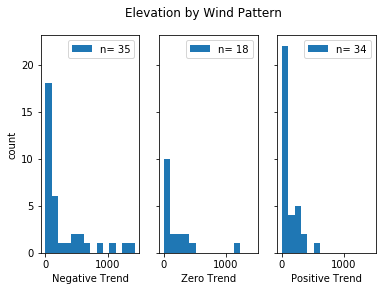

In [54]:
#Look at the elevation by change in wind speed pattern
b = np.linspace(0,max(df.elev),15)
#fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex = True);
fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharey = True);
ax1.hist(dfNeg["elev"],bins=b,label = "n= "+str(len(dfNeg["elev"])));
ax1.set_ylabel("count")
ax1.set_xlabel("Negative Trend")
ax1.legend()

ax2.hist(dfZero["elev"],bins=b,label = "n= "+str(len(dfZero["elev"])));
ax2.set_xlabel("Zero Trend")
ax2.legend()

ax3.hist(dfPos["elev"],bins = b,label = "n= "+str(len(dfPos["elev"])));
ax3.set_xlabel("Positive Trend")
ax3.legend()

fig.suptitle("Elevation by Wind Pattern");

In [55]:
# are these distributions different? (they don't look it...)
# we use a Kolmogorov-Smirnov test
e1 = dfNeg["elev"]
e2 = dfZero['elev']
e3 = dfPos['elev']
for dist in [e1,e2,e3]:
    for dist2 in [e1,e2,e3]:
        print(stats.ks_2samp(dist,dist2))

Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.20158730158730154, pvalue=0.6682378959329579)
Ks_2sampResult(statistic=0.27058823529411763, pvalue=0.13346046176425486)
Ks_2sampResult(statistic=0.20158730158730154, pvalue=0.6682378959329579)
Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.2777777777777778, pvalue=0.27518807616285823)
Ks_2sampResult(statistic=0.27058823529411763, pvalue=0.13346046176425486)
Ks_2sampResult(statistic=0.2777777777777778, pvalue=0.27518807616285823)
Ks_2sampResult(statistic=0.0, pvalue=1.0)


In [56]:
# A GeoDataFrame needs a shapely object, so we create a new 
#column 'coordinates' as a tuple of 'lat' and 'lon'
df['coordinates'] = list(zip(df.lon, df.lat)) #(x,y ==> lon,lat)

#transform tuples to Point
df['coordinates'] = df['coordinates'].apply(Point)

#now we can create the GeoDataFrame by setting geometry with 
#previosly created coordinates
gdf = gpd.GeoDataFrame(df,geometry= 'coordinates')

In [74]:
#Need to set the coordinate system (epsg:4269 = NAD83 datum)
gdf.crs = {'init' :'epsg:3857'}

In [75]:
#we need to add a string column that represents slopeInt for better
#plotting
def createString(gdf):
    if gdf["slopeInt"] == -1:
        return "Negative"
    elif gdf["slopeInt"] ==0:
        return "Zero"
    elif gdf["slopeInt"]==1:
        return "Positive"
    else:
        return "Big trouble in little china!"
gdf['trend'] = gdf.apply(createString, axis = 1)
gdf.head(2)

,stationNumber,slope,lowBound,hightBound,slopeInt,pw1972,pw2017,elev,lat,lon,coordinates,trend
0,483570-99999,-0.134197,-0.185880,-0.082513,-1,135.0,74.0,148.0,17.417,104.783,POINT (104.783 17.417),Negative
1,722310-12916,-0.083380,-0.148009,-0.018750,-1,78.0,121.0,1.2,29.998,-90.278,POINT (-90.27800000000001 29.998),Negative


In [76]:
# Create a dictionary where you assign each attribute value to a particular color
trendPalette = {"Negative": 'b',
               "Positive": 'r',
               "Zero": 'grey'}

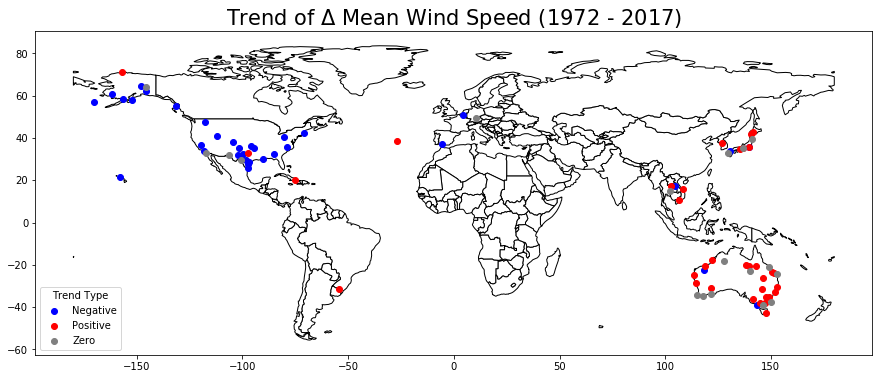

In [77]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name!="Antarctica"]
#plot the data
fig,ax = plt.subplots(figsize=(15,15))
world.plot(color = 'white',
           edgecolor = 'black',
           ax = ax)

#loop through each attribute type and plot it using the colors assigned to the dictionary
for ctype, data in gdf.groupby("trend"):
    color = trendPalette[ctype]
    data.plot(color = color,
              ax = ax,
              label = ctype)
ax.legend(title = "Trend Type",
          loc = "lower left");
ax.set_title("Trend of $\Delta$ Mean Wind Speed (1972 - 2017)", fontsize = 21);


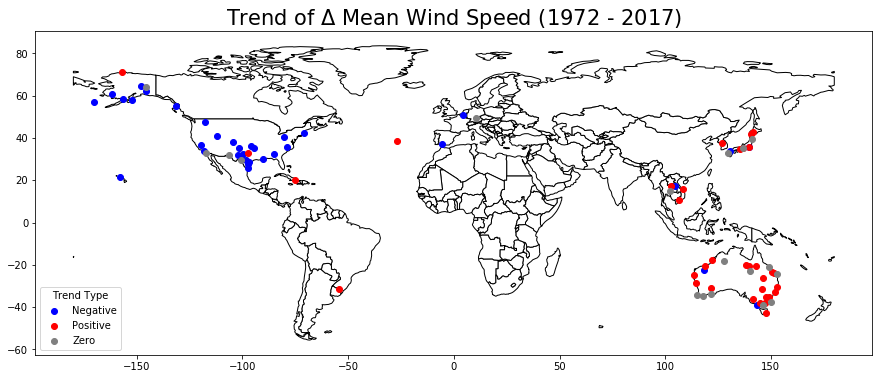

In [78]:
ax.figure

In [79]:
mplleaflet.display(fig=ax.figure, crs=world.crs)

ValueError: Unrecognized code: C